In [1]:
import tensorflow as tf
import keras
from keras import layers
import os
import numpy as np
from sklearn.model_selection import train_test_split
import scipy
import matplotlib.pyplot as plt
import time
import cv2

2024-06-15 17:36:38.493517: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 17:36:38.493635: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 17:36:38.622048: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
srcdata = scipy.io.loadmat('/kaggle/input/ofdmdataset-mehransoltani/ofdm_data/My_noisy_H_22.mat')
rcvdata = scipy.io.loadmat('/kaggle/input/ofdmdataset-mehransoltani/ofdm_data/Perfect_H_40000.mat')
srcdata_ofdm= abs(srcdata['My_noisy_H']).reshape(-1,72,14,1)
rcvdata_ofdm= abs(rcvdata['My_perfect_H']).reshape(-1,72,14,1)
# trainData,testData, trainLabels, testLabels = train_test_split(srcdata_ofdm,rcvdata_ofdm,test_size=0.2,shuffle=False)

In [3]:
OUTPUT_CHANNELS = 1
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=1, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [4]:
inp=srcdata_ofdm[1]
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 72, 14, 3)


In [5]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=1,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [6]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 72, 14, 3)


In [7]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[72, 14, 1])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=1,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

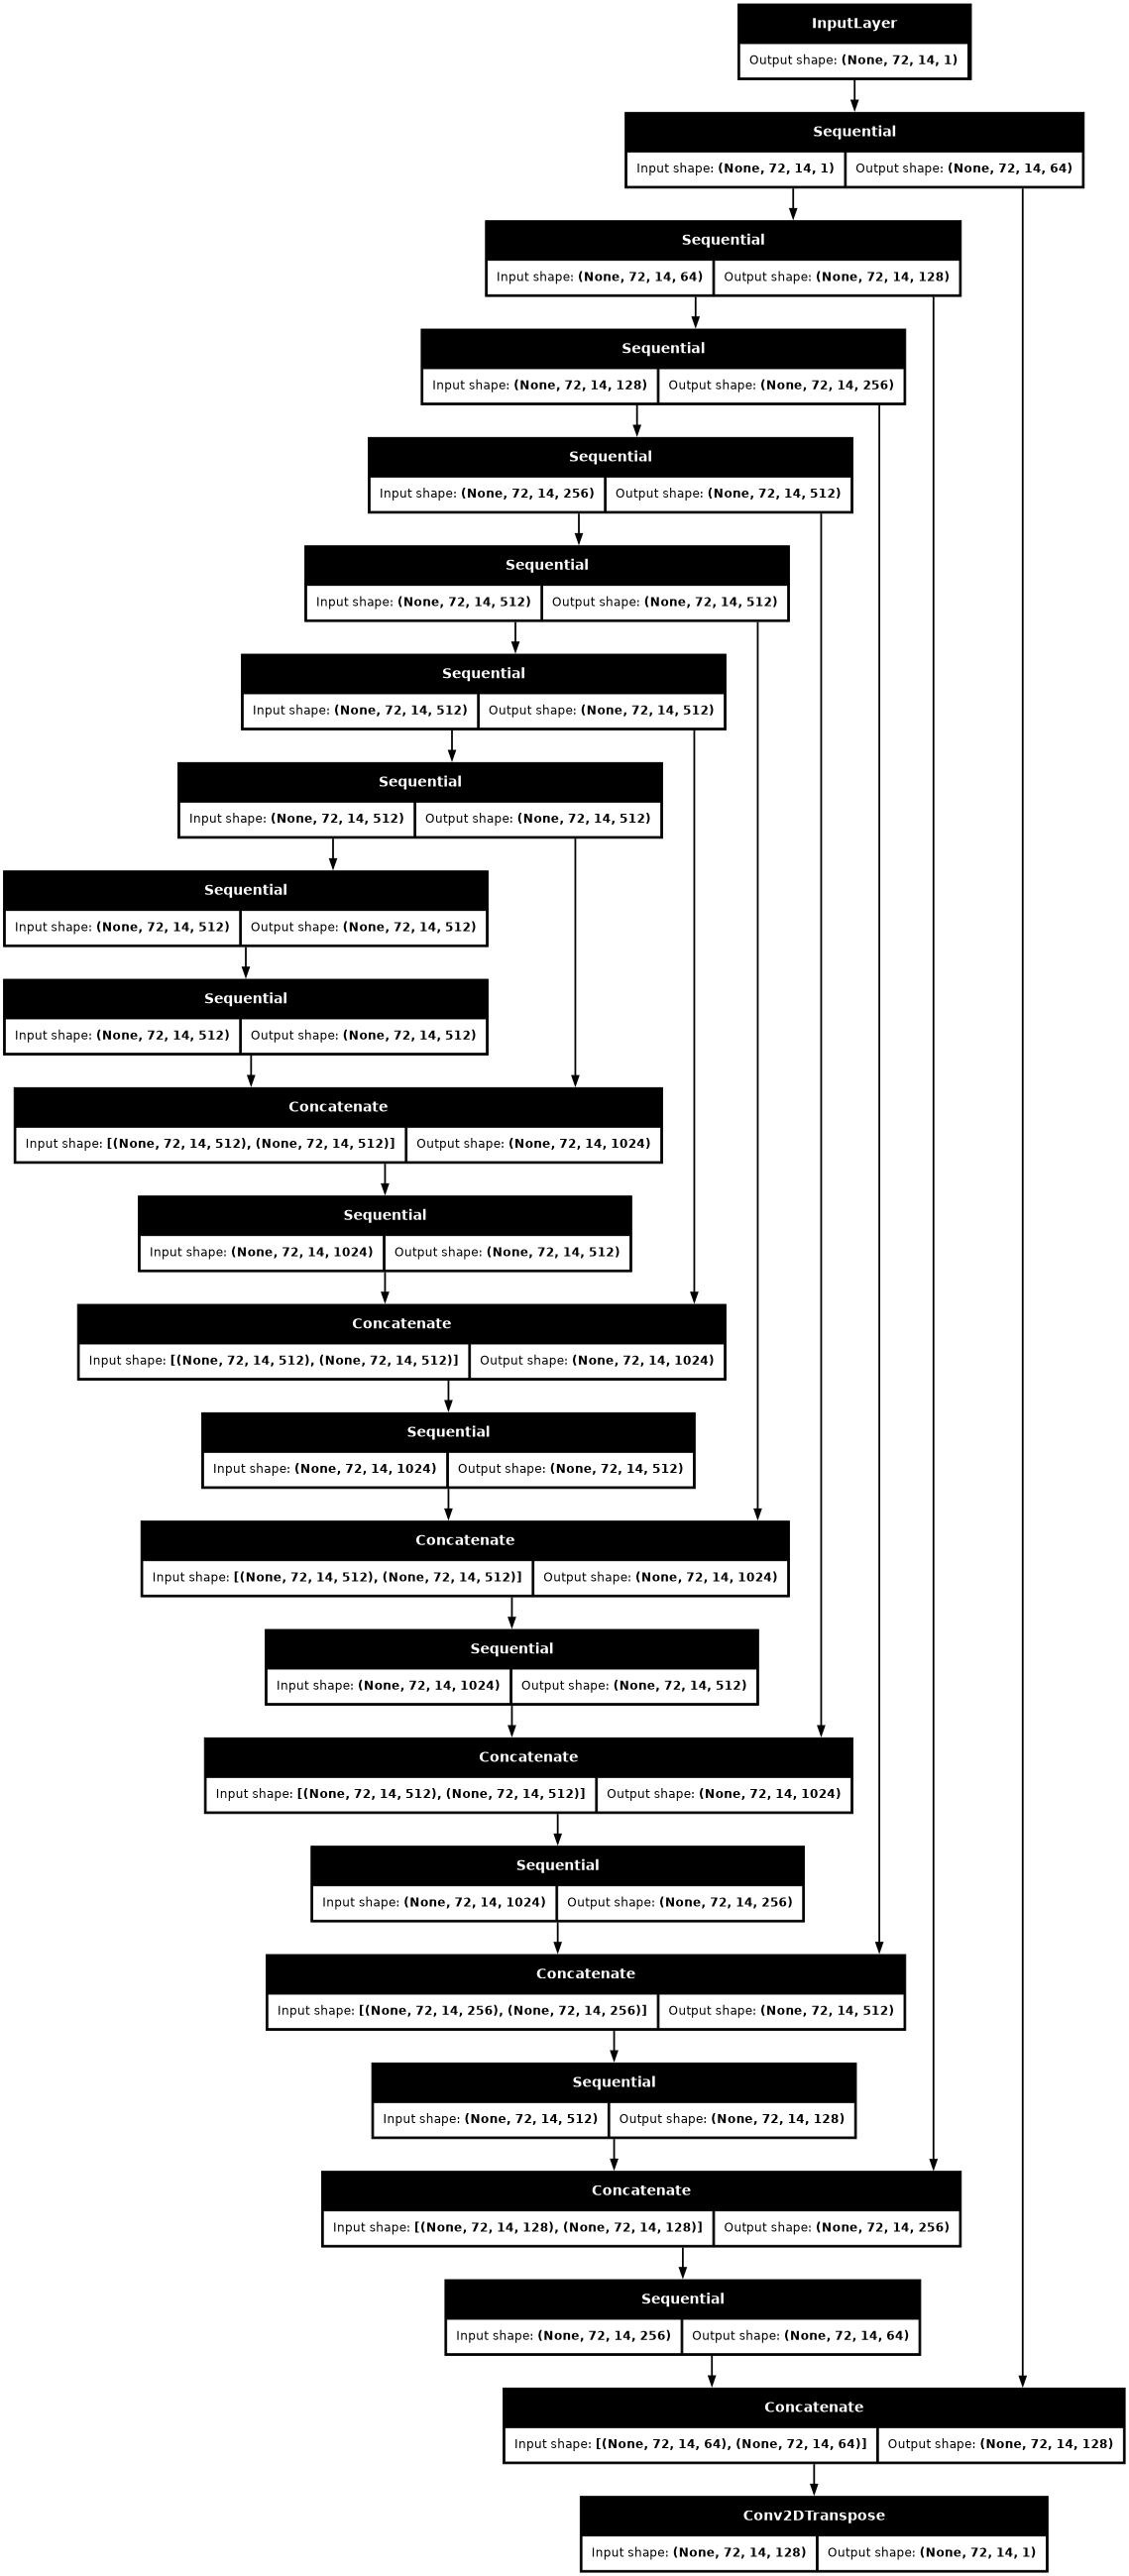

In [8]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

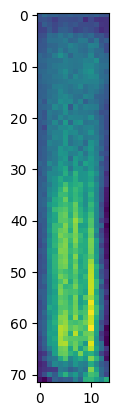

In [9]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [10]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = tf.cast(loss_object(tf.ones_like(tf.cast(disc_generated_output,dtype=tf.float64)), tf.cast(disc_generated_output,dtype=tf.float64)),dtype=tf.float64)

  # Mean absolute error
  l1_loss = tf.cast(tf.reduce_mean(tf.abs(tf.cast(target,dtype=tf.float64) - tf.cast(gen_output,dtype=tf.float64))),dtype=tf.float64)

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [11]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inpt = tf.keras.layers.Input(shape=[72, 14, 1], name='input_image')
  tar = tf.keras.layers.Input(shape=[72, 14, 1], name='target_image')

  x = tf.keras.layers.concatenate([inpt, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(1, 4, strides=1,padding='same',
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,padding='same',
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inpt, tar], outputs=last)

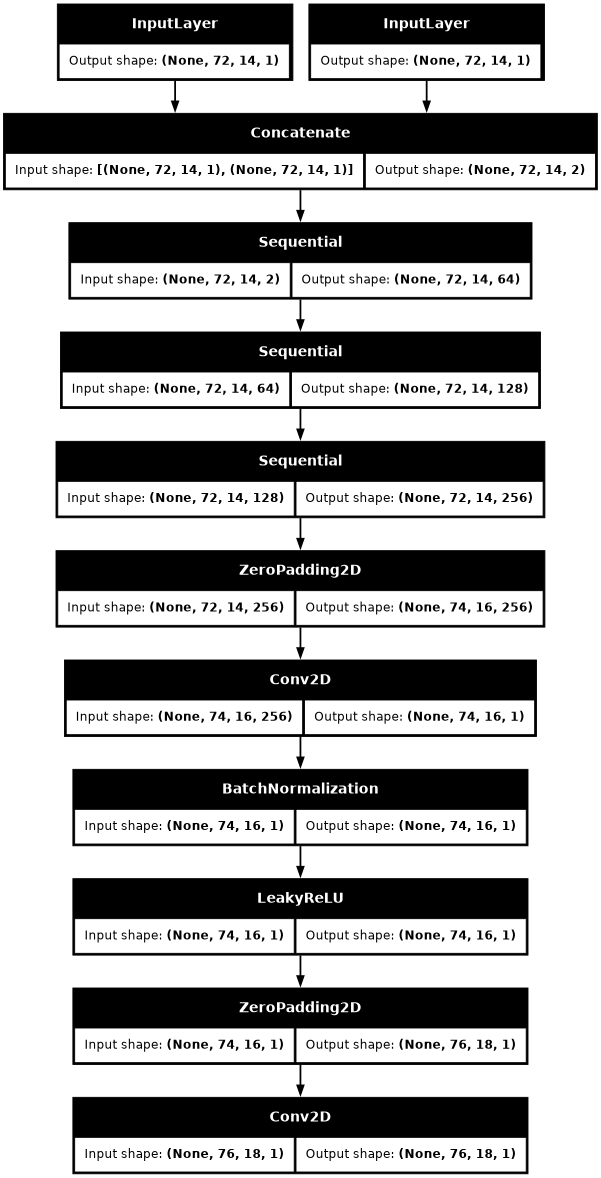

In [12]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [13]:
# disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
# plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
# plt.colorbar()

In [14]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = tf.cast(loss_object(tf.ones_like(tf.cast(disc_real_output,dtype=tf.float64)), tf.cast(disc_real_output,dtype=tf.float64)),dtype=tf.float64)

  generated_loss = tf.cast(loss_object(tf.zeros_like(tf.cast(disc_generated_output,dtype=tf.float64)), tf.cast(disc_generated_output,dtype=tf.float64)),dtype=tf.float64)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [16]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [17]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

#   with summary_writer.as_default():
#     tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
#     tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
#     tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
#     tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [18]:
def generate_images(model, test_input, tar):
  prediction = model(test_input.reshape(1,72,14,1), training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input, tar, prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [19]:
trainData,testData, trainLabels, testLabels = train_test_split(srcdata_ofdm,rcvdata_ofdm,test_size=0.2,shuffle=False)

In [20]:
trainset=(trainData, trainLabels)
trainset=np.transpose(trainset,[1,0,2,3,4])
testset=(testData, testLabels)
testset=np.transpose(testset,[1,0,2,3,4])

In [21]:
import random
import numpy as np
a=random.choice(trainset)
np.shape(a)

(2, 72, 14, 1)

In [22]:
import random
import numpy as np
def fit(train_ds, test_ds, steps):
  #(example_input, example_target) = next(iter(test_ds))
  (example_input, example_target) = random.choice(test_ds)
  start = time.time()

  for step, images in enumerate(train_ds):
    (example_input, example_target) = random.choice(test_ds)
    if (step) % 50 == 0:
      #display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 50 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//50}k")

    train_step(images[0].reshape(1,72,14,1).astype(np.float64), images[1].reshape(1,72,14,1).astype(np.float64), step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 25 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

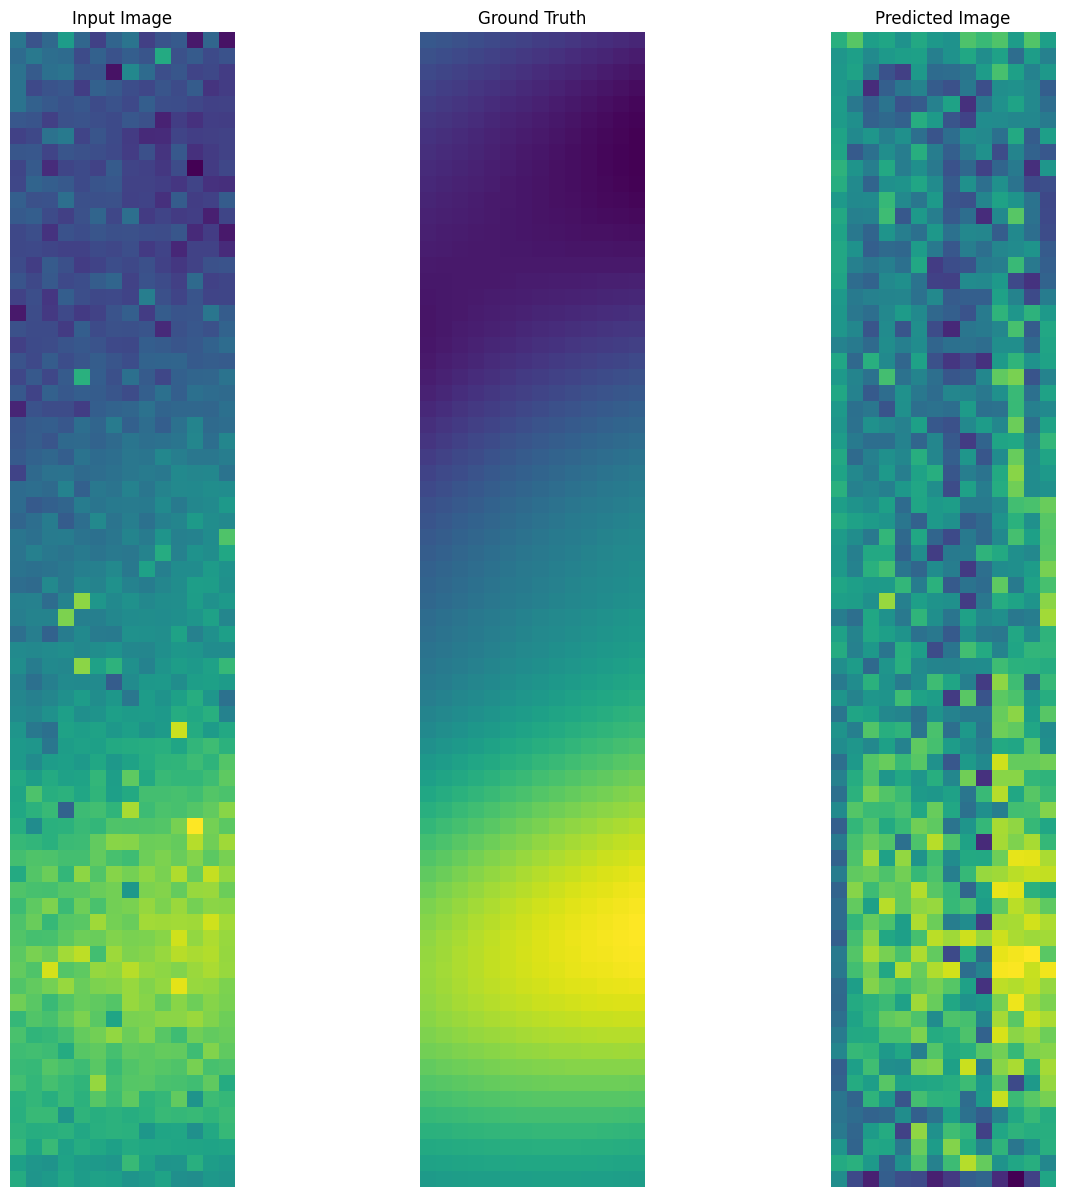

Step: 0k


2024-06-15 17:37:26.213163: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_18_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-06-15 17:38:28.856813: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_18_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-06-15 17:39:30.554699: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_18_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


..

2024-06-15 17:40:35.045235: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_18_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.Time taken for 50 steps: 244.75 sec



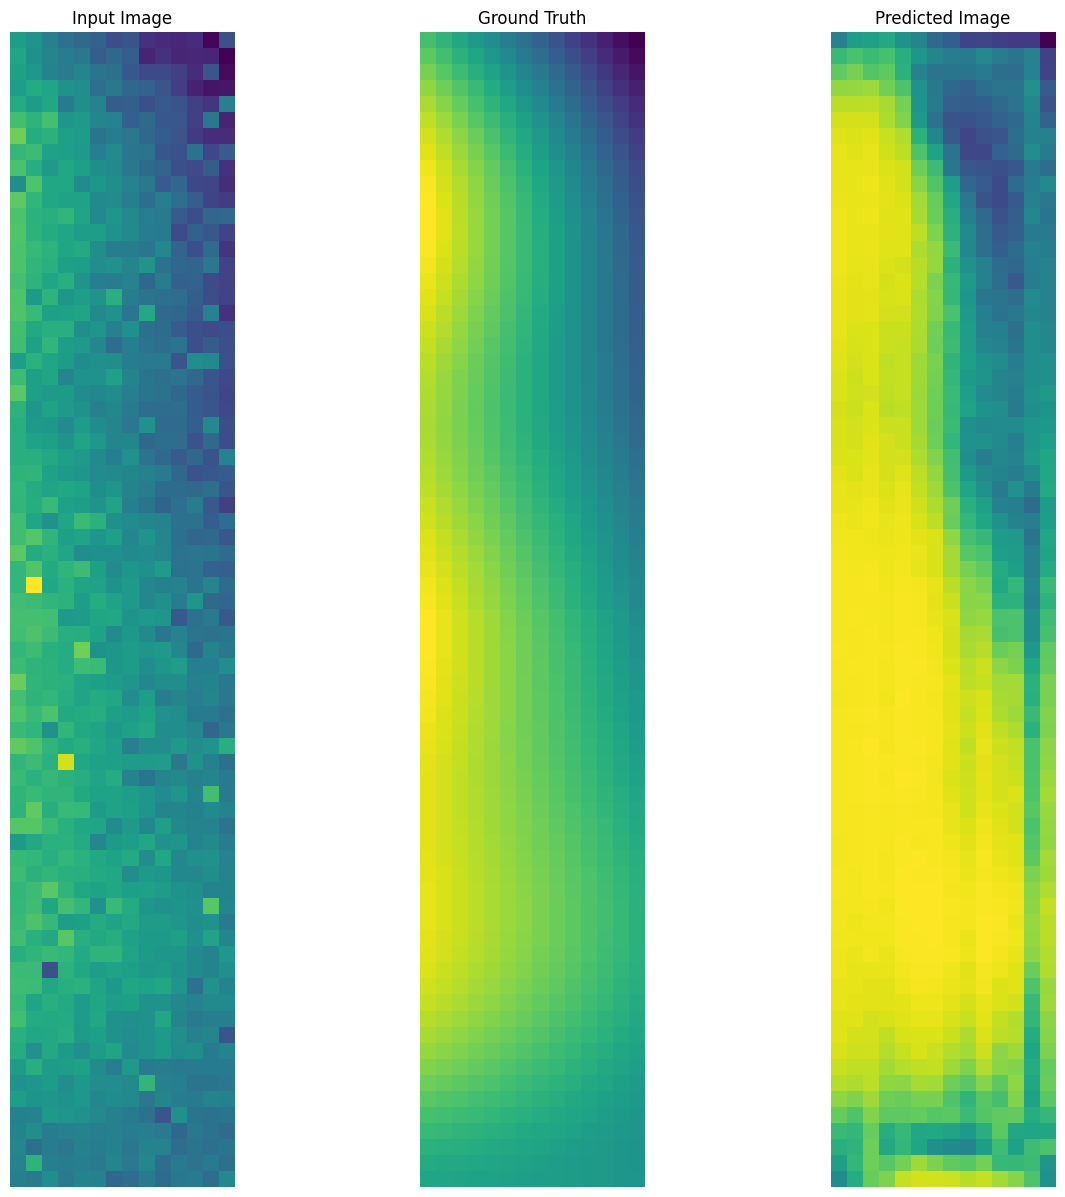

Step: 1k


2024-06-15 17:41:37.247536: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_18_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-06-15 17:42:37.757988: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_18_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-06-15 17:43:37.972630: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_18_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


..

2024-06-15 17:44:39.400994: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_18_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.Time taken for 50 steps: 234.13 sec



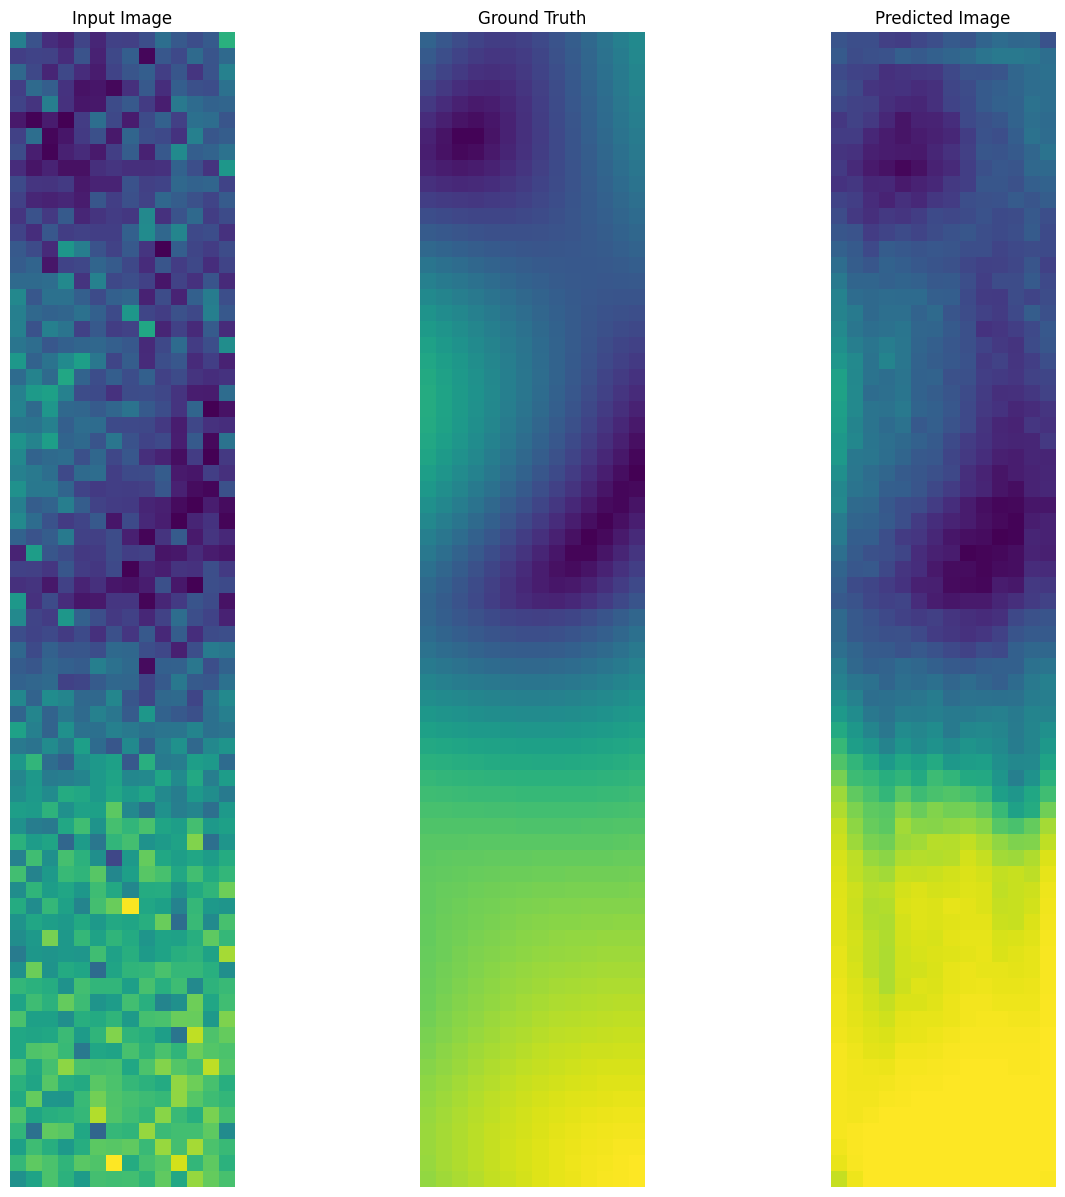

Step: 2k


2024-06-15 17:45:43.165598: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_18_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-06-15 17:46:46.856188: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_18_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


..

2024-06-15 17:47:47.566951: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_18_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-06-15 17:48:49.883197: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_18_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.Time taken for 50 steps: 236.90 sec



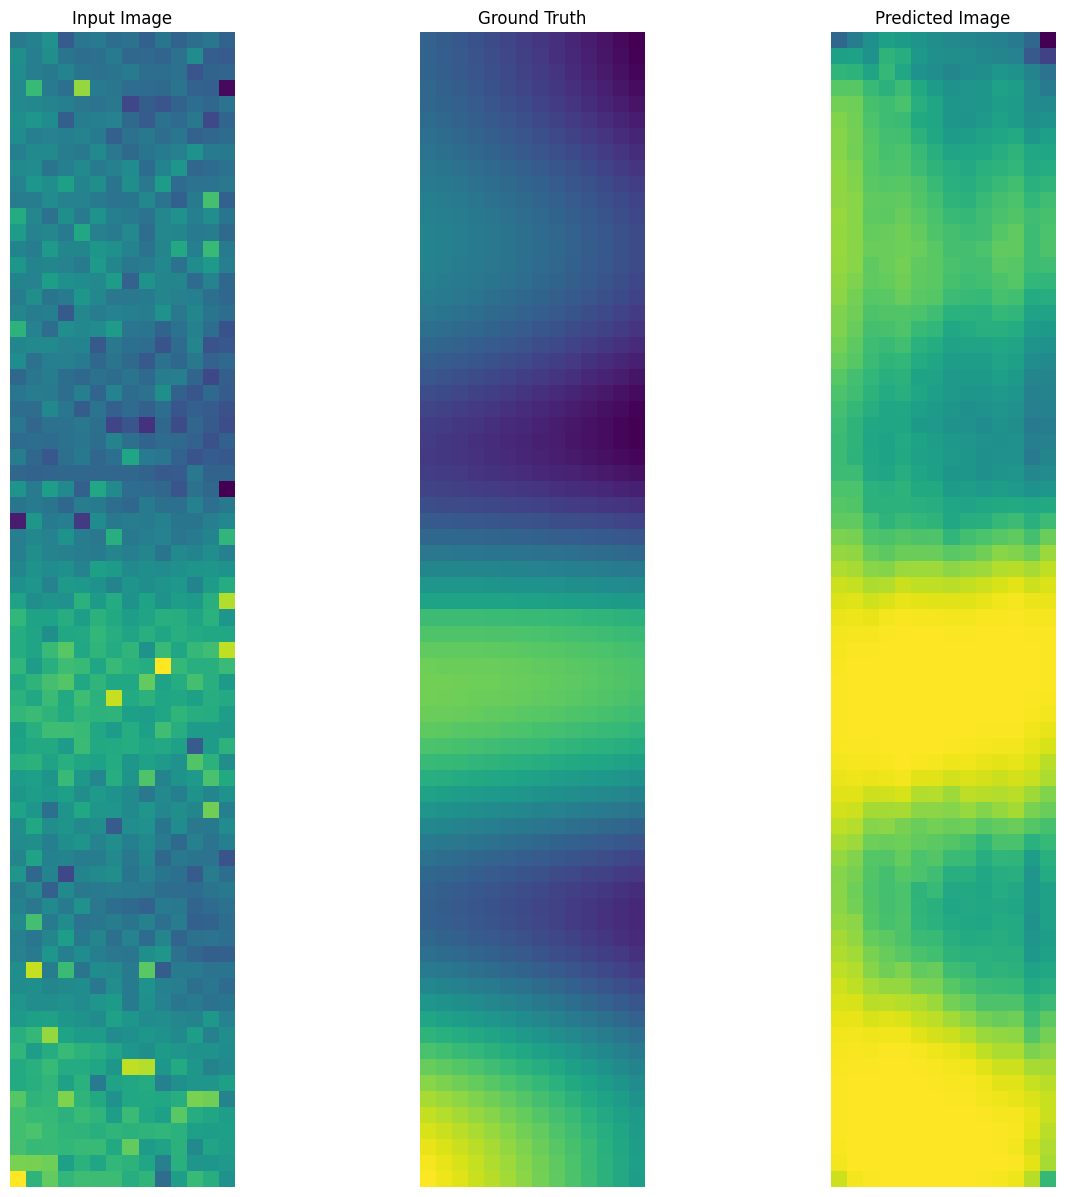

Step: 3k


2024-06-15 17:49:51.069840: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_18_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


..

2024-06-15 17:50:54.412889: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_18_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-06-15 17:51:55.655675: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_18_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-06-15 17:52:59.800951: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_18_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.Time taken for 50 steps: 236.25 sec



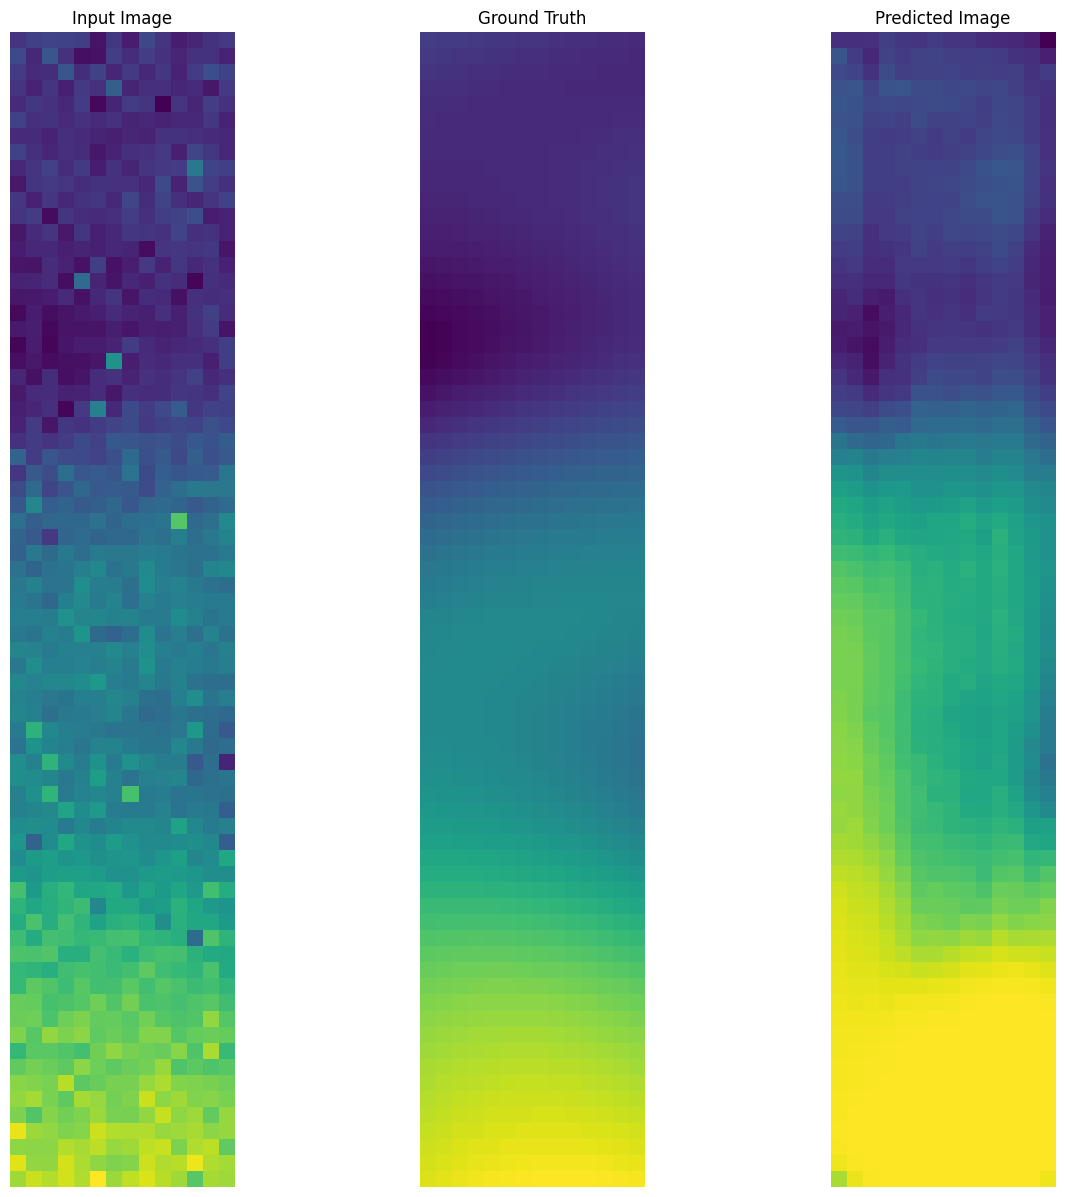

Step: 4k


In [ ]:
fit(trainset, testset, steps=1000)